<a href="https://colab.research.google.com/github/Rjpiit/Image-processing-and-Audio-Reconstruction/blob/master/Task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task 4 (Q1)**

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.kernel_approximation import RBFSampler

# Function to download an image if not already present
def download_image():
    import os
    if not os.path.exists('/content/wild-rabbit.jpg'):
        !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O wild-rabbit.jpg
    print("Image loaded successfully.")


# Matrix Factorization Function using Gradient Descent, ignoring NaN values
def factorize(A, k, num_iters=1000, lr=0.01, device=torch.device("cpu")):
    A = A.to(device)

    # Randomly initialize W and H
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)

    # Optimizer
    optimizer = optim.Adam([W, H], lr=lr)

    # Mask to ignore NaN values
    mask = ~torch.isnan(A)

    # Train the model
    for i in range(num_iters):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    return W, H, loss

# Function to calculate RMSE
def calculate_rmse(original, reconstructed, mask):
    error = (original[mask] - reconstructed[mask]) ** 2
    return torch.sqrt(torch.mean(error)).item()

# Function to calculate PSNR
def calculate_psnr(original, reconstructed, mask):
    mse = torch.mean((original[mask] - reconstructed[mask]) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = torch.max(original[mask])
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr.item()

Using device: cpu
Image loaded successfully.
Number of masked pixels: 47922
Iteration 0, Loss: 2371.9560546875
Iteration 100, Loss: 257.7130126953125
Iteration 200, Loss: 40.930423736572266
Iteration 300, Loss: 34.818321228027344
Iteration 400, Loss: 32.77933883666992
Iteration 500, Loss: 31.218053817749023
Iteration 600, Loss: 29.782197952270508
Iteration 700, Loss: 28.504846572875977
Iteration 800, Loss: 27.404634475708008
Iteration 900, Loss: 26.40389633178711


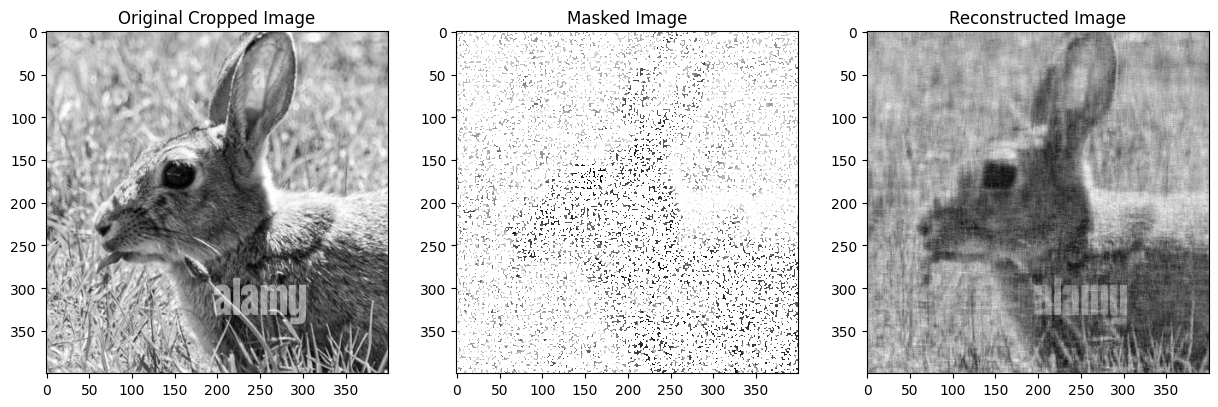

RMSE: 0.0762702077627182
PSNR: 22.352901458740234


In [ ]:
# Function to mask a certain proportion of the image
def mask_image(img, prop, device):
    img_copy = img.clone().to(device)  # Move to correct device
    mask = torch.rand(img.shape, device=device) < prop  # Ensure mask is also on the device
    img_copy[mask] = float('nan')
    return img_copy, mask

# Main Function for Image Loading, Masking, Factorization, and Plotting
def main():
    # Set device to GPU if available, otherwise CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Download image if not present
    download_image()

    # Read the image using torchvision
    img = torchvision.io.read_image("/content/wild-rabbit.jpg").float() / 255.0  # Normalize image to [0, 1]
    img = img.mean(dim=0)  # Convert to grayscale by averaging RGB channels

    # Crop the image to a smaller size
    crop = F.crop(img, top=200, left=400, height=400, width=400)
    crop = crop.to(device)  # Move to GPU or CPU based on availability

    # Mask the cropped image
    masked_img, mask = mask_image(crop, 0.3, device)  # Mask 30% of the pixels
    print(f"Number of masked pixels: {mask.sum().item()}")

    # Perform matrix factorization to reconstruct the image
    rank = 50  # Set the rank for the factorization
    W, H, loss = factorize(masked_img, rank, num_iters=1000, lr=0.01, device=device)

    # Reconstruct the image
    reconstructed_img = torch.mm(W, H).cpu().detach().numpy()

    # Plot original cropped vs masked and reconstructed image
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(crop.cpu().numpy(), cmap='gray')
    ax[0].set_title('Original Cropped Image')
    ax[1].imshow(masked_img.cpu().numpy(), cmap='gray')
    ax[1].set_title('Masked Image')
    ax[2].imshow(reconstructed_img, cmap='gray')
    ax[2].set_title('Reconstructed Image')
    plt.show()

    # Calculate and display RMSE and PSNR
    masked_area = ~mask  # Inverted mask for non-NaN pixels
    rmse = calculate_rmse(crop, torch.tensor(reconstructed_img).to(device), masked_area)
    psnr = calculate_psnr(crop, torch.tensor(reconstructed_img).to(device), masked_area)

    print(f"RMSE: {rmse}")
    print(f"PSNR: {psnr}")

# Run the main function
if __name__ == "__main__":
    main()


**Q2**


Using device: cpu
Image loaded successfully.
Number of masked pixels: 900
Iteration 0, Loss: 2820.91943359375
Iteration 100, Loss: 302.8058776855469
Iteration 200, Loss: 50.880184173583984
Iteration 300, Loss: 43.4390754699707
Iteration 400, Loss: 40.50777816772461
Iteration 500, Loss: 38.54902648925781
Iteration 600, Loss: 37.01216506958008
Iteration 700, Loss: 35.64947509765625
Iteration 800, Loss: 34.471893310546875
Iteration 900, Loss: 33.3193359375


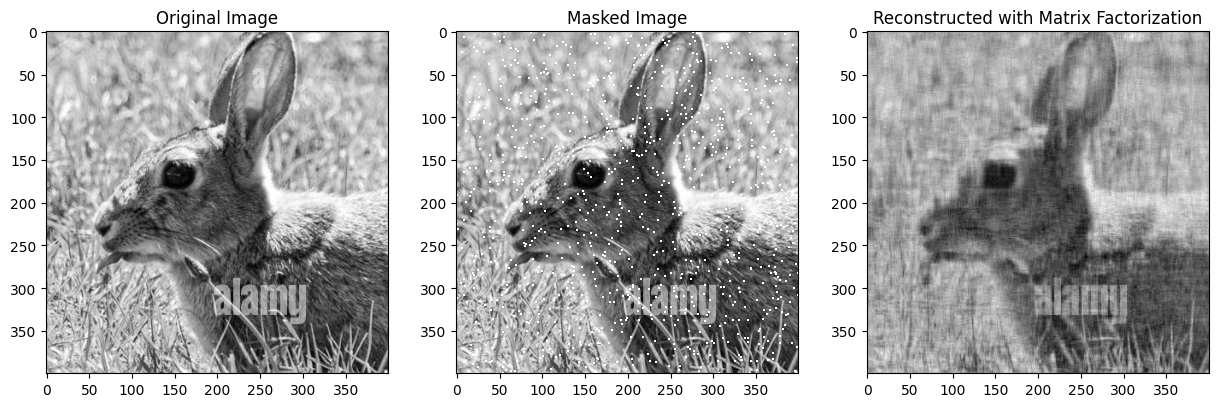

Matrix Factorization - RMSE: 0.08107504993677139, PSNR: 21.822254180908203


In [ ]:

# Function to randomly mask 900 pixels from the image
def mask_900_pixels(img):
    img_copy = img.clone()
    mask = torch.zeros_like(img_copy).bool()  # Create an all-false mask
    indices = torch.randperm(img_copy.numel())[:900]  # Randomly choose 900 indices
    mask.view(-1)[indices] = True  # Set the corresponding pixels to True
    img_copy[mask] = float('nan')  # Mask the chosen pixels
    return img_copy, mask


# Main Function for Image Loading, Masking, Factorization, and Plotting
def main():
    # Set device to GPU if available, otherwise CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Download image if not present
    download_image()

    # Read the image using torchvision
    img = torchvision.io.read_image("/content/wild-rabbit.jpg").float() / 255.0  # Normalize image to [0, 1]
    img = img.mean(dim=0)  # Convert to grayscale by averaging RGB channels

    # Crop the image to a smaller size
    crop = F.crop(img, top=200, left=400, height=400, width=400)
    crop = crop.to(device)  # Move to GPU or CPU based on availability

    # Mask 900 random pixels
    masked_img, mask = mask_900_pixels(crop)
    print(f"Number of masked pixels: {mask.sum().item()}")

    # Perform matrix factorization to reconstruct the image
    rank = 50  # Set the rank for the factorization
    W, H, loss = factorize(masked_img, rank, num_iters=1000, lr=0.01, device=device)

    # Reconstruct the image using matrix factorization
    reconstructed_img_mf = torch.mm(W, H).cpu().detach().numpy()

    # Plot original, masked, and matrix factorized images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(crop.cpu().numpy(), cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(masked_img.cpu().numpy(), cmap='gray')
    ax[1].set_title('Masked Image')
    ax[2].imshow(reconstructed_img_mf, cmap='gray')
    ax[2].set_title('Reconstructed with Matrix Factorization')
    plt.show()

    # Calculate and display RMSE and PSNR
    masked_area = ~mask  # Inverted mask for non-NaN pixels
    rmse_mf = calculate_rmse(crop, torch.tensor(reconstructed_img_mf).to(device), masked_area)
    psnr_mf = calculate_psnr(crop, torch.tensor(reconstructed_img_mf).to(device), masked_area)

    print(f"Matrix Factorization - RMSE: {rmse_mf}, PSNR: {psnr_mf}")

# Run the main function
if __name__ == "__main__":
    main()


Image loaded successfully.
Number of masked pixels: 900


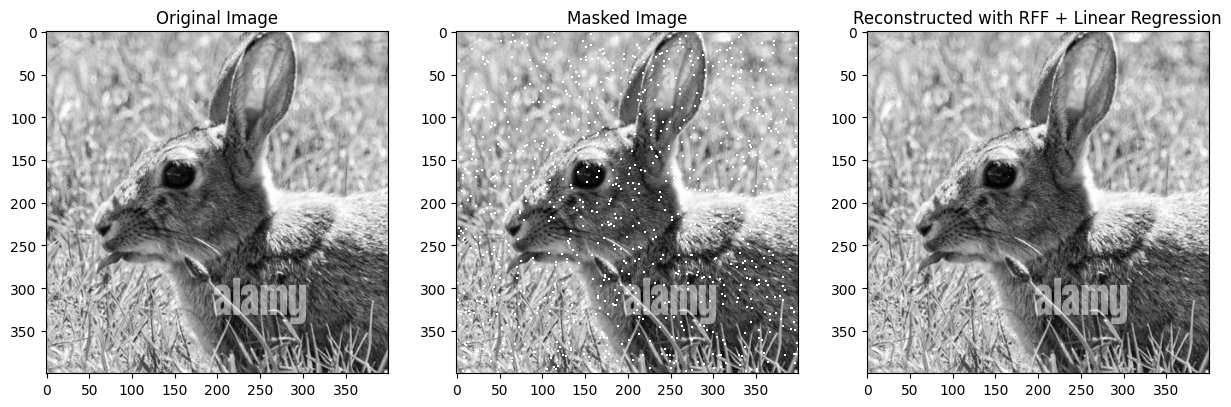

RFF + Linear Regression - RMSE: 0.0, PSNR: inf


In [ ]:
# Reconstruct using Random Fourier Features + Linear Regression
def reconstruct_with_rff(original, mask, num_features=500):
    """Reconstruct missing pixels using RFF and Linear Regression."""
    device = original.device  # Get the current device (GPU or CPU)

    # Get known and missing pixel coordinates
    X_known = torch.nonzero(~mask).cpu()  # Coordinates of known pixels, moved to CPU
    y_known = original[~mask].cpu().numpy()  # Known pixel values on CPU

    # Get missing pixel coordinates
    X_missing = torch.nonzero(mask).cpu()  # Coordinates of missing pixels on CPU

    # Create RFF transformer
    rbf_sampler = RBFSampler(n_components=num_features, random_state=42)

    # Transform the known and missing coordinates using RFF
    X_known_rff = rbf_sampler.fit_transform(X_known.numpy())
    X_missing_rff = rbf_sampler.transform(X_missing.numpy())

    # Fit Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(X_known_rff, y_known)

    # Predict the missing pixel values
    y_pred = lr_model.predict(X_missing_rff)

    # Reconstruct the image
    reconstructed_img = original.clone()
    reconstructed_img[mask] = torch.tensor(y_pred, dtype=torch.float32).to(device)  # Move prediction to original's device

    return reconstructed_img

# Main Function for Image Loading, Masking, RFF + Linear Regression, and Plotting
def main():
    # Download image if not present
    download_image()

    # Read the image using torchvision
    img = torchvision.io.read_image("/content/wild-rabbit.jpg").float() / 255.0  # Normalize image to [0, 1]
    img = img.mean(dim=0)  # Convert to grayscale by averaging RGB channels

    # Crop the image to a smaller size
    crop = F.crop(img, top=200, left=400, height=400, width=400)

    # Check if GPU is available and set the device accordingly
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    crop = crop.to(device)  # Move to the available device (GPU or CPU)

    # Mask 900 random pixels
    masked_img, mask = mask_900_pixels(crop)
    print(f"Number of masked pixels: {mask.sum().item()}")

    # Reconstruct the image using RFF and Linear Regression
    reconstructed_img_rff = reconstruct_with_rff(crop, mask)

    # Plot original, masked, and RFF reconstructed images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(crop.cpu().numpy(), cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(masked_img.cpu().numpy(), cmap='gray')
    ax[1].set_title('Masked Image')
    ax[2].imshow(reconstructed_img_rff.cpu().numpy(), cmap='gray')
    ax[2].set_title('Reconstructed with RFF + Linear Regression')
    plt.show()

    # Calculate and display RMSE and PSNR
    masked_area = ~mask  # Inverted mask for non-NaN pixels
    rmse_rff = calculate_rmse(crop, reconstructed_img_rff, masked_area)
    psnr_rff = calculate_psnr(crop, reconstructed_img_rff, masked_area)

    print(f"RFF + Linear Regression - RMSE: {rmse_rff}, PSNR: {psnr_rff}")

# Run the main function
if __name__ == "__main__":
    main()


RFF + Linear Regression method is better than Matrix Factorization.